In [86]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

from qiskit import transpile
from qiskit_aer import AerSimulator  # as of 25Mar2025
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT, UnitaryGate, PhaseGate, RZGate
from qiskit.quantum_info import Operator

# import basic plot tools
from qiskit.visualization import plot_histogram

<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\e'
C:\Users\rodcs\AppData\Local\Temp\ipykernel_23472\2182805489.py:5: SyntaxWarning: invalid escape sequence '\e'
  """


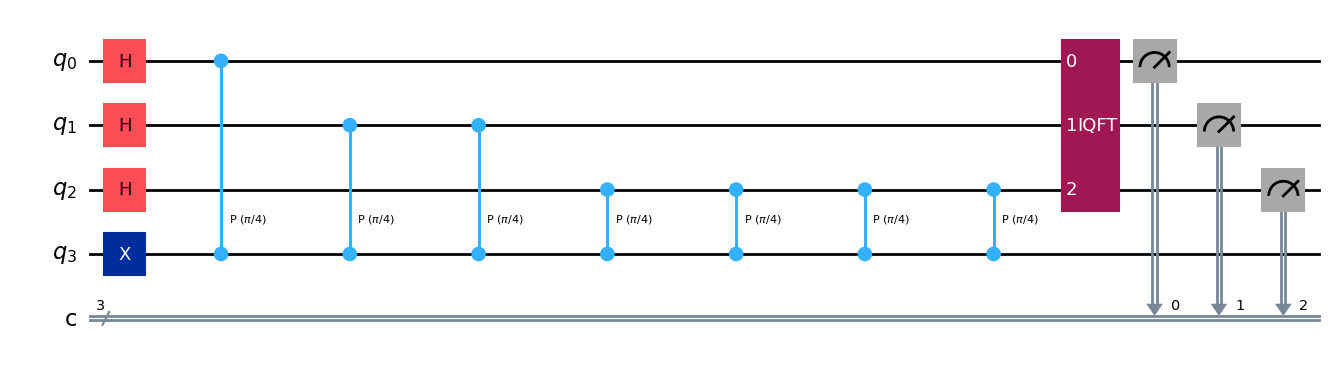

In [87]:
# The dumbest possible test: Phase gate
# The dumbest possible implementation of the QPE algorithm: someone else´s code: https://github.com/qiskit-community/qiskit-textbook/blob/0ae905083ec3872d7ddc6bb4001d5468f476d93f/content/ch-algorithms/quantum-phase-estimation.ipynb

def generate_qpe_circuit_simple(total_qubits, phase):
    """
    Assumptions: 
    - The target unitary acts on *one* qubit (the last one)
    - The target unitary is a phase gate:
        P(\theta) =
                \begin{pmatrix}
                    1 & 0 \\
                    0 & e^{i\theta}
                \end{pmatrix}
    """
    num_ancilla = total_qubits-1
    qpe = QuantumCircuit(total_qubits, num_ancilla) # num qubits, num classical bits (to store meaurements)
    qpe.x(num_ancilla) # because ket(1) is an eigenvector of the phase gate

    for qubit in range(num_ancilla):
        qpe.h(qubit)
        
    repetitions = 1
    for counting_qubit in range(num_ancilla):
        for i in range(repetitions):
            qpe.cp(phase, counting_qubit, num_ancilla); # Apply C-PhaseGate to last qubit (target qubit) controlled by counting qubit
        repetitions *= 2
        
    # Apply the inverse QFT
    list_of_ancilla_qubits = [i for i in range(num_ancilla)]
    qpe.append(QFT(3, inverse=True), list_of_ancilla_qubits) 

    qpe.measure(list_of_ancilla_qubits, list_of_ancilla_qubits) # Measure the ancilla qubits
    return qpe

qpe = generate_qpe_circuit_simple(total_qubits=4, phase=math.pi/4)
qpe.draw('mpl')

SANITY CHECK:

$$ U = \begin{pmatrix}
                    1 & 0 \\
                    0 & e^{i\theta}
                \end{pmatrix} $$

So, for $|\lambda \rangle = |1\rangle$  we have $U |1\rangle = e^{i\theta} |1\rangle$ 

In happy cases, we have $ \theta = \frac{2 \pi k}{2^n} $ where $k$ is an integer and $n$ is the number of ancilla qubits and the number read in the ancila register willbe exactly $k$.

Experiments:
Let n = 3, so we have 3 ancilla qubits. The possible values of $k$ are $0, 1, 2, 3, 4, 5, 6, 7$.
- $k = 1 \implies \theta = \frac{2 \pi}{8} = \frac{\pi}{4}$
- $k = 2 \implies \theta = \frac{4 \pi}{8} = \frac{\pi}{2}$
- $k = 3 \implies \theta = \frac{6 \pi}{8} = \frac{3\pi}{4}$
- $k = 4 \implies \theta = \frac{8 \pi}{8} = \pi$
- $k = 5 \implies \theta = \frac{10 \pi}{8} = \frac{5\pi}{4}$
- $k = 6 \implies \theta = \frac{12 \pi}{8} = \frac{3\pi}{2}$
- $k = 7 \implies \theta = \frac{14 \pi}{8} = \frac{7\pi}{4}$
...

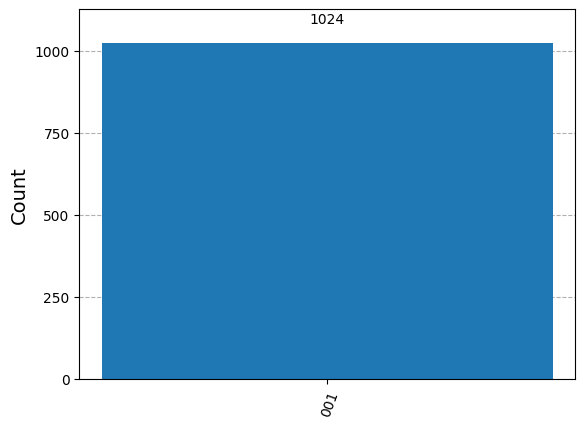

In [88]:
simulator = AerSimulator()
job = simulator.run(transpile(qpe, simulator), shots=1024)
result = job.result()
counts = result.get_counts(qpe)
plot_histogram(counts)

In [89]:
# I will become an English major if this doesn't work
most_frequent_bitstring = max(counts, key=counts.get)
print(f"Most frequent bitstring:{most_frequent_bitstring} (as int: {int(most_frequent_bitstring, 2)})")
print("Estimated phase:", math.pi * 2 * int(most_frequent_bitstring, 2) / (2**3))
print("Real phase:", math.pi / 4)   

Most frequent bitstring:001 (as int: 1)
Estimated phase: 0.7853981633974483
Real phase: 0.7853981633974483


In [90]:
qpe = generate_qpe_circuit_simple(total_qubits=4, phase=math.pi/2)
# run the circuit again
job = simulator.run(transpile(qpe, simulator), shots=1024)
result = job.result()
counts = result.get_counts(qpe)
most_frequent_bitstring = max(counts, key=counts.get)
print(f"Most frequent bitstring:{most_frequent_bitstring} (as int: {int(most_frequent_bitstring, 2)})")
print("Estimated phase:", math.pi * 2 * int(most_frequent_bitstring, 2) / (2**3))
print("Real phase:", math.pi / 2)


Most frequent bitstring:010 (as int: 2)
Estimated phase: 1.5707963267948966
Real phase: 1.5707963267948966


In [ ]:
# k = 3
qpe = generate_qpe_circuit_simple(total_qubits=4, phase=3*math.pi/4)
job = simulator.run(transpile(qpe, simulator), shots=1024)
result = job.result()
counts = result.get_counts(qpe)
most_frequent_bitstring = max(counts, key=counts.get)
print(f"Most frequent bitstring:{most_frequent_bitstring} (as int: {int(most_frequent_bitstring, 2)})")
print("Estimated phase:", math.pi * 2 * int(most_frequent_bitstring, 2) / (2**3))
print("Real phase:", 3*math.pi/4)

Most frequent bitstring:011 (as int: 3)
Estimated phase: 2.356194490192345
Real phase: 2.356194490192345


In [92]:
# k = 4, theta = pi
qpe = generate_qpe_circuit_simple(total_qubits=4, phase=math.pi)
job = simulator.run(transpile(qpe, simulator), shots=1024)
result = job.result()
counts = result.get_counts(qpe)
most_frequent_bitstring = max(counts, key=counts.get)
print(f"Most frequent bitstring:{most_frequent_bitstring} (as int: {int(most_frequent_bitstring, 2)})")
print("Estimated phase:", math.pi * 2 * int(most_frequent_bitstring, 2) / (2**3))
print("Real phase:", math.pi)

Most frequent bitstring:100 (as int: 4)
Estimated phase: 3.141592653589793
Real phase: 3.141592653589793


In [93]:
# k = 5, theta = 5pi/4
qpe = generate_qpe_circuit_simple(total_qubits=4, phase=5*math.pi/4)
job = simulator.run(transpile(qpe, simulator), shots=1024)
result = job.result()
counts = result.get_counts(qpe)
most_frequent_bitstring = max(counts, key=counts.get)
print(f"Most frequent bitstring:{most_frequent_bitstring} (as int: {int(most_frequent_bitstring, 2)})")
print("Estimated phase:", math.pi * 2 * int(most_frequent_bitstring, 2) / (2**3))
print("Real phase:", 5*math.pi/4)

Most frequent bitstring:101 (as int: 5)
Estimated phase: 3.9269908169872414
Real phase: 3.9269908169872414


In [94]:
# k = 6, theta = 3pi/2
qpe = generate_qpe_circuit_simple(total_qubits=4, phase=3*math.pi/2)
job = simulator.run(transpile(qpe, simulator), shots=1024)
result = job.result()
counts = result.get_counts(qpe)
most_frequent_bitstring = max(counts, key=counts.get)
print(f"Most frequent bitstring:{most_frequent_bitstring} (as int: {int(most_frequent_bitstring, 2)})")
print("Estimated phase:", math.pi * 2 * int(most_frequent_bitstring, 2) / (2**3))
print("Real phase:", 3*math.pi/2)

Most frequent bitstring:110 (as int: 6)
Estimated phase: 4.71238898038469
Real phase: 4.71238898038469


In [95]:
# k = 7 theta = 7pi/4
qpe = generate_qpe_circuit_simple(total_qubits=4, phase=7*math.pi/4)
job = simulator.run(transpile(qpe, simulator), shots=1024)
result = job.result()
counts = result.get_counts(qpe)
most_frequent_bitstring = max(counts, key=counts.get)
print(f"Most frequent bitstring:{most_frequent_bitstring} (as int: {int(most_frequent_bitstring, 2)})")
print("Estimated phase:", math.pi * 2 * int(most_frequent_bitstring, 2) / (2**3))
print("Real phase:", 7*math.pi/4)

Most frequent bitstring:111 (as int: 7)
Estimated phase: 5.497787143782138
Real phase: 5.497787143782138


In [ ]:
# k = 10, theta = 10pi/4 = 5pi/2
qpe = generate_qpe_circuit_simple(total_qubits=4, phase=5*math.pi/2)
job = simulator.run(transpile(qpe, simulator), shots=1024)
result = job.result()
counts = result.get_counts(qpe)
most_frequent_bitstring = max(counts, key=counts.get)
print(f"Most frequent bitstring:{most_frequent_bitstring} (as int: {int(most_frequent_bitstring, 2)})")
print("Estimated phase:", math.pi * 2 * int(most_frequent_bitstring, 2) / (2**3))
print("Real phase:", 5*math.pi/2)
# wraps around the circle!

Most frequent bitstring:010 (as int: 2)
Estimated phase: 1.5707963267948966
Real phase: 7.853981633974483


## Ok but what if $ \nexists  k \in \mathbb{N}$ such that $ \theta = \frac{2 \pi k}{2^n} $?

The analysis in Nielsen and Chuang says we only need $U |\lambda \rangle = e^{2 \pi \varphi}$. 

They define the "best t-bit approximation" $\tilde{\varphi}$ of $\varphi$ as $\frac{m}{2^t}$, where $m$ is the integer that minimizes $|\varphi - \frac{m}{2^t}|$

Experiments: let t = 3, so we have 3 ancilla qubits. The possible values of $m$ are $0, 1, 2, 3, 4, 5, 6, 7$.
- let $\varphi = 0.6 \implies \tilde{\varphi} = \frac{5}{8} = 0.625$, so we expect to measure $5$ in the ancilla register, which has a binary representation of 101.

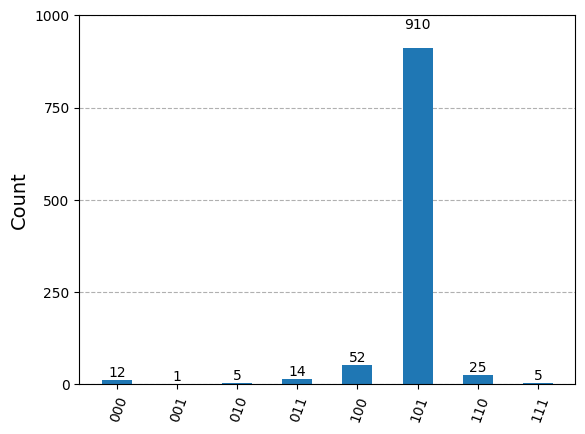

In [103]:
theta = 2*math.pi * 0.6
qpe = generate_qpe_circuit_simple(total_qubits=4, phase=theta)
job = simulator.run(transpile(qpe, simulator), shots=1024)
result = job.result()
counts = result.get_counts(qpe)
plot_histogram(counts)


In [ ]:
most_frequent_bitstring = max(counts, key=counts.get)
print(f"Most frequent bitstring:{most_frequent_bitstring} (as int: {int(most_frequent_bitstring, 2)})")
print("Estimated phase:", math.pi * 2 * int(most_frequent_bitstring, 2) / (2**3))
print("Real phase:", theta)
print(f"Estimated phi = {(math.pi * 2 * int(most_frequent_bitstring, 2) / (2**3))/(2*math.pi)}")
print(f"Real phi = {theta/(2*math.pi)}")

Most frequent bitstring:101 (as int: 5)
Estimated phase: 3.9269908169872414
Real phase: 3.7699111843077517
Estimated phi = 0.625
Real phi = 0.6


: 